# Predicting Closed Companies Using Crunchbase Data

In [1]:
# Loading the preamble:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
pd.options.display.float_format = '{:.4f}'.format
import datetime as dt
import matplotlib.dates as mdates
%matplotlib inline
plt.style.use('default')
import warnings
warnings.filterwarnings("ignore")
import sklearn
from sklearn.utils import resample
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_selection import SelectKBest
from matplotlib import rcParams
from sklearn.utils import resample
rcParams.update({'figure.autolayout': True})

In [15]:
# Loading datasets with information about companies and people of crunchbase.com
crunchbase = pd.read_csv("crunchbase.csv", encoding='mac_roman')
people = pd.read_csv("people.csv")

## Data Manipulation and Exploratory Analysis

In [16]:
# Peak at the data
crunchbase.head()

,name,homepage_url,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at
0,#waywire,http://www.waywire.com,News,"1,750,000",acquired,USA,NY,New York City,New York,1,6/1/12,2012-06,2012-Q2,2012.0000,6/30/12,6/30/12
1,&TV Communications,http://enjoyandtv.com,Games,"4,000,000",operating,USA,CA,Los Angeles,Los Angeles,2,NaN,NaN,NaN,nan,6/4/10,9/23/10
2,'Rock' Your Paper,http://www.rockyourpaper.org,Publishing,"40,000",operating,EST,NaN,Tallinn,Tallinn,1,10/26/12,2012-10,2012-Q4,2012.0000,8/9/12,8/9/12
3,(In)Touch Network,http://www.InTouchNetwork.com,Electronics,"1,500,000",operating,GBR,NaN,London,London,1,4/1/11,2011-04,2011-Q2,2011.0000,4/1/11,4/1/11
4,#NAME?,http://plusn.com,Software,"1,200,000",operating,USA,NY,New York City,New York,2,1/1/12,2012-01,2012-Q1,2012.0000,8/29/12,9/4/14


In [17]:
crunchbase.status.value_counts()

operating    39675
acquired      3508
closed        2846
Name: status, dtype: int64

In [18]:
list(crunchbase.columns)

['name',
 'homepage_url',
 ' market ',
 ' funding_total_usd ',
 'status',
 'country_code',
 'state_code',
 'region',
 'city',
 'funding_rounds',
 'founded_at',
 'founded_month',
 'founded_quarter',
 'founded_year',
 'first_funding_at',
 'last_funding_at']

In [19]:
people.head()

,crunchbase_uuid,type,first_name,last_name,crunchbase_url,profile_image_url,facebook_url,twitter_url,linkedin_url,location_city,location_region,location_country_code,title,organization,organization_crunchbase_url
0,ed13cd36-fe2b-3707-197b-0c2d56e37a71,Person,Ben,Elowitz,https://www.crunchbase.com/person/ben-elowitz?...,https://crunchbase-production-res.cloudinary.c...,http://www.facebook.com/elowitz,http://twitter.com/elowitz,http://www.linkedin.com/in/benelowitz,NaN,NaN,NaN,"Advisor at Connected Signals, Inc.","Connected Signals, Inc.",https://www.crunchbase.com/organization/connec...
1,5ceca97b-493c-1446-6249-5aaa33464763,Person,Kevin,Flaherty,https://www.crunchbase.com/person/kevin-flaher...,https://crunchbase-production-res.cloudinary.c...,NaN,https://twitter.com/tallkp,http://www.linkedin.com/in/kevinflaherty,NaN,NaN,NaN,Team Member at DRSmedia,DRSmedia,https://www.crunchbase.com/organization/drs650...
2,9f99a98a-aa97-b30b-0d36-db67c1d277e0,Person,Raju,Vegesna,https://www.crunchbase.com/person/raju-vegesna...,https://crunchbase-production-res.cloudinary.c...,NaN,NaN,https://www.linkedin.com/pub/raju-vegesna/1/65...,San Francisco,California,US,Chief Evangelist at Zoho,Zoho,https://www.crunchbase.com/organization/zoho
3,6e1bca72-a865-b518-b305-31214ce2d1b0,Person,Ian,Wenig,https://www.crunchbase.com/person/ian-wenig?ut...,https://crunchbase-production-res.cloudinary.c...,NaN,NaN,http://www.linkedin.com/profile/view?id=1633445,NaN,NaN,NaN,VP Business Development at Zoho,Zoho,https://www.crunchbase.com/organization/zoho
4,80d25c23-9726-9dda-5852-39cdf4810ea5,Person,Ron,Gorodetzky,https://www.crunchbase.com/person/ron-gorodetz...,https://crunchbase-production-res.cloudinary.c...,NaN,NaN,https://twitter.com/ronwinbeta,NaN,NaN,NaN,Co-Founder and CTO at fflick,fflick,https://www.crunchbase.com/organization/fflick


In [20]:
list(people.columns)

['crunchbase_uuid',
 'type',
 'first_name',
 'last_name',
 'crunchbase_url',
 'profile_image_url',
 'facebook_url',
 'twitter_url',
 'linkedin_url',
 'location_city',
 'location_region',
 'location_country_code',
 'title',
 'organization',
 'organization_crunchbase_url']

In [21]:
crunchbase = crunchbase.rename(columns={' funding_total_usd ': 'funding_total_usd',' market ' : 'market'})

In [22]:
crunchbase.dtypes

name                  object
homepage_url          object
market                object
funding_total_usd     object
status                object
country_code          object
state_code            object
region                object
city                  object
funding_rounds         int64
founded_at            object
founded_month         object
founded_quarter       object
founded_year         float64
first_funding_at      object
last_funding_at       object
dtype: object

In [23]:
# Tranforming funding column to numerical format
crunchbase['funding_total_usd'] = crunchbase['funding_total_usd'].replace(',', '', regex=True)
crunchbase['funding_total_usd'] = crunchbase['funding_total_usd'].replace('-', '0', regex=True)
crunchbase['funding_total_usd'] = pd.to_numeric(crunchbase['funding_total_usd'])
crunchbase['funding_total_usd'] = crunchbase['funding_total_usd'].astype(float)

In [24]:
crunchbase['funding_total_usd'].describe()

count         47758.0000
mean       14823086.7894
std       392557453.6164
min               0.0000
25%           54319.0000
50%         1015000.0000
75%         7000000.0000
max     78795064652.0000
Name: funding_total_usd, dtype: float64

In [25]:
crunchbase['funding_rounds'].describe()

count   47758.0000
mean        1.6886
std         1.2821
min         1.0000
25%         1.0000
50%         1.0000
75%         2.0000
max        17.0000
Name: funding_rounds, dtype: float64

In [26]:
crunchbase['market'].describe()

count          42465
unique           717
top        Software 
freq            4534
Name: market, dtype: object

In [27]:
# Top 5 markets by company count
crunchbase['market'].value_counts(normalize=True).head(5)

 Software         0.1068
 Biotechnology    0.0861
 Mobile           0.0462
 E-Commerce       0.0418
 Curated Web      0.0390
Name: market, dtype: float64

In [28]:
# Top 10 countries by company count
crunchbase['country_code'].value_counts(normalize=True).head(10)

USA   0.6540
GBR   0.0598
CAN   0.0315
CHN   0.0283
DEU   0.0214
FRA   0.0197
IND   0.0182
ISR   0.0152
ESP   0.0118
JPN   0.0089
Name: country_code, dtype: float64

In [30]:
crunchbase['status'].value_counts(normalize=True).head()

# only around 6% of companies present on crunchbase.com are registered as "closed"

operating   0.8620
acquired    0.0762
closed      0.0618
Name: status, dtype: float64

In [31]:
# Check number of unique companies in dataframe
crunchbase['name'].nunique()

47672

In [35]:
# Check median of funding
print("Median funding: ${}".format(crunchbase['funding_total_usd'].median()))

Median funding: $1015000.0


In [36]:
# Aggregate people on chrunchbase by organisation/company
people = people.groupby(['organization']).agg({'crunchbase_uuid': "nunique"})

In [37]:
people.head()

,crunchbase_uuid
organization,
\nBELL RESOURCES,1
\nCentiel,1
\nCoalition,2
\nCurofy,2
\nDataBroker DAO,4


In [38]:
people.describe()

,crunchbase_uuid
count,208928.0000
mean,2.7647
std,7.0069
min,1.0000
25%,1.0000
50%,2.0000
75%,3.0000
max,1336.0000


In [39]:
# This will create a new index (from 0 to XY), organization will become a column 
people = people.reset_index()

In [40]:
people.head()

,organization,crunchbase_uuid
0,\nBELL RESOURCES,1
1,\nCentiel,1
2,\nCoalition,2
3,\nCurofy,2
4,\nDataBroker DAO,4


In [41]:
# Get rid of \n
people['organization'] = people['organization'].replace('\n', '', regex=True)

In [42]:
people.head()

,organization,crunchbase_uuid
0,BELL RESOURCES,1
1,Centiel,1
2,Coalition,2
3,Curofy,2
4,DataBroker DAO,4


In [43]:
# Create master dataframe from organizations AND people
master = pd.merge(crunchbase, people, left_on=['name'], right_on=['organization'])

In [44]:
master.head()

,name,homepage_url,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at,organization,crunchbase_uuid
0,#waywire,http://www.waywire.com,News,1750000.0000,acquired,USA,NY,New York City,New York,1,6/1/12,2012-06,2012-Q2,2012.0000,6/30/12,6/30/12,#waywire,2
1,'Rock' Your Paper,http://www.rockyourpaper.org,Publishing,40000.0000,operating,EST,NaN,Tallinn,Tallinn,1,10/26/12,2012-10,2012-Q4,2012.0000,8/9/12,8/9/12,'Rock' Your Paper,2
2,(In)Touch Network,http://www.InTouchNetwork.com,Electronics,1500000.0000,operating,GBR,NaN,London,London,1,4/1/11,2011-04,2011-Q2,2011.0000,4/1/11,4/1/11,(In)Touch Network,3
3,-R- Ranch and Mine,NaN,Games,10000.0000,operating,USA,TX,Dallas,Fort Worth,1,7/8/14,2014-07,2014-Q3,2014.0000,8/17/14,8/17/14,-R- Ranch and Mine,1
4,.Club Domains,http://nic.club/,Software,7000000.0000,NaN,USA,FL,Ft. Lauderdale,Oakland Park,1,10/10/11,2011-10,2011-Q4,2011.0000,5/31/13,5/31/13,.Club Domains,1


In [45]:
# Check number of observations and columns
print(master.shape)
print(crunchbase.shape)
print(people.shape)

(31929, 18)
(47758, 16)
(208928, 2)


In [48]:
# Creating dummies for company status
master['closed']=0
master['closed'][master['status'] == 'closed']=1

master['operating']=0
master['operating'][master['status'] == 'operating']=1

master['acquired']=0
master['acquired'][master['status'] == 'acquired']=1

In [50]:
# Checking correlations between company status and numerical variables
master.corr()

,funding_total_usd,funding_rounds,founded_year,crunchbase_uuid,closed,operating,acquired
funding_total_usd,1.0000,0.0370,-0.0745,0.0546,-0.0027,-0.0018,0.0036
funding_rounds,0.0370,1.0000,-0.0840,0.1346,-0.0140,-0.0508,0.0723
founded_year,-0.0745,-0.0840,1.0000,-0.0825,0.0190,0.0869,-0.1065
crunchbase_uuid,0.0546,0.1346,-0.0825,1.0000,-0.0222,0.0129,-0.0028
closed,-0.0027,-0.0140,0.0190,-0.0222,1.0000,-0.4159,-0.0405
operating,-0.0018,-0.0508,0.0869,0.0129,-0.4159,1.0000,-0.7078
acquired,0.0036,0.0723,-0.1065,-0.0028,-0.0405,-0.7078,1.0000


In [51]:
master.describe()

,funding_total_usd,funding_rounds,founded_year,crunchbase_uuid,closed,operating,acquired
count,31929.0000,31929.0000,26158.0000,31929.0000,31929.0000,31929.0000,31929.0000
mean,17861365.2739,1.7979,2007.5556,3.7136,0.0232,0.8791,0.0645
std,479308595.7265,1.3780,7.3290,10.2547,0.1507,0.3260,0.2456
min,0.0000,1.0000,1902.0000,1.0000,0.0000,0.0000,0.0000
25%,75000.0000,1.0000,2006.0000,1.0000,0.0000,1.0000,0.0000
50%,1157940.0000,1.0000,2010.0000,2.0000,0.0000,1.0000,0.0000
75%,7800000.0000,2.0000,2012.0000,4.0000,0.0000,1.0000,0.0000
max,78795064652.0000,17.0000,2014.0000,1336.0000,1.0000,1.0000,1.0000


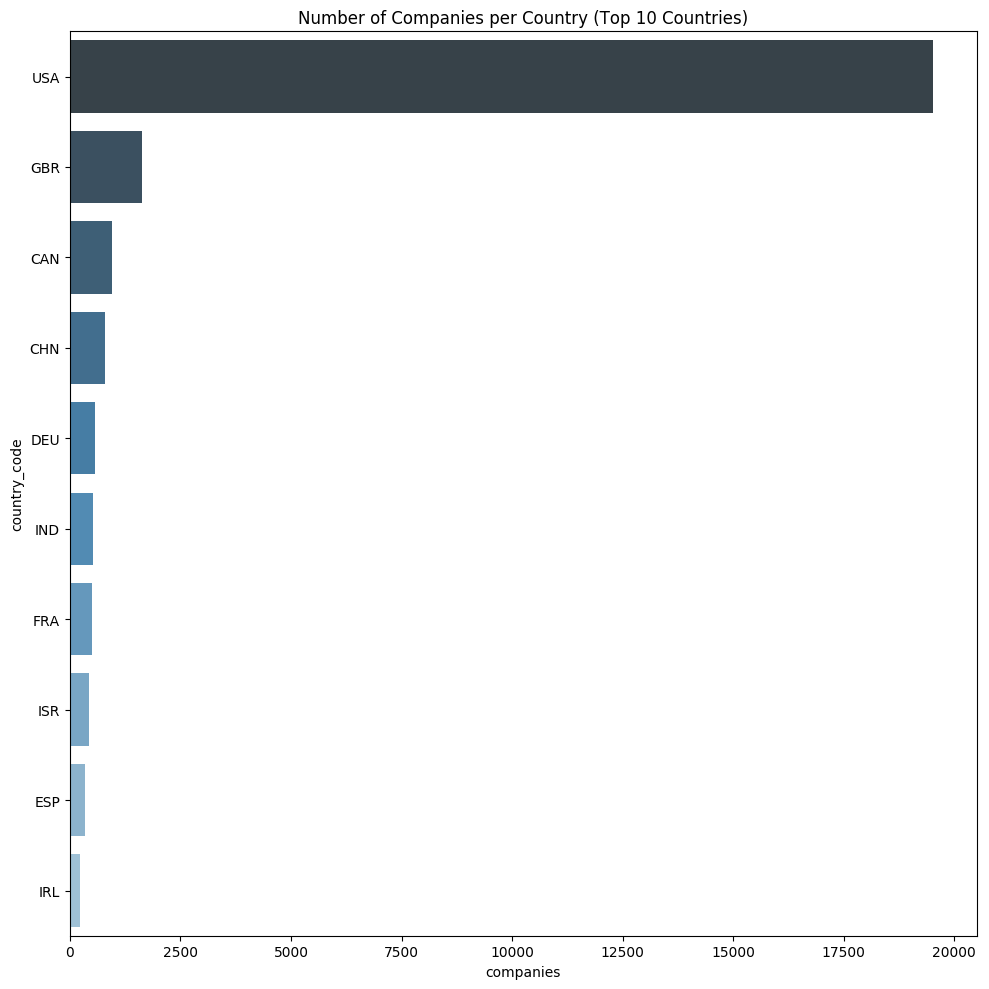

In [52]:
countries = master.groupby(['country_code'])[['name']].nunique()
countries.columns = ['companies']
countries = countries.reset_index().sort_values(by=['companies'], ascending=False)

top10_countries = countries.head(10)
plt.figure(figsize=(10,10))
plt.title('Number of Companies per Country (Top 10 Countries)')
sns.barplot(y ='country_code', x='companies',data = top10_countries, palette="Blues_d")
#plt.tight_layout()
plt.savefig('companies_per_country_top10.png', dpi=300, transparent=True)

In [53]:
master_non_usa = master[master['country_code'] != 'USA']
master_deu = master[master['country_code'] == 'DEU'] 
master_gbr = master[master['country_code'] == 'GBR'] 

In [54]:
master['usa'] = 0
master['usa'][master['country_code'] == 'USA']=1

In [55]:
master['usa'].value_counts()

1    19563
0    12366
Name: usa, dtype: int64

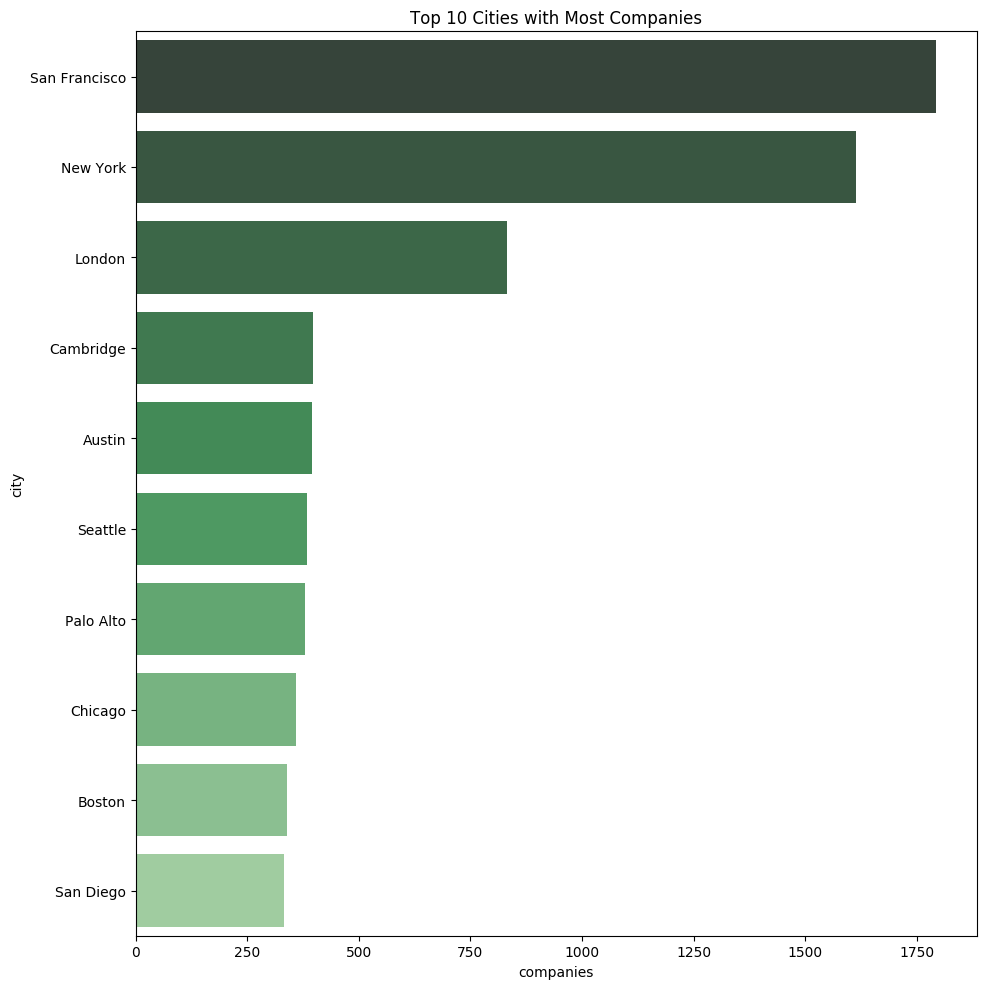

In [56]:
cities = master.groupby(['city'])[['name']].nunique()
cities.columns = ['companies']
cities = cities.reset_index().sort_values(by=['companies'], ascending=False)

top10_cities = cities.head(10)
plt.figure(figsize=(10,10))
sns.barplot(y ='city', x='companies',data = top10_cities, palette="Greens_d")
#plt.tight_layout()
plt.title('Top 10 Cities with Most Companies')
plt.savefig('top10_cities.png', dpi=300, transparent=True)

In [58]:
cities_funding = master.groupby(['city']).agg({'name': "nunique",
                                              'funding_total_usd': 'sum'})
cities_funding = cities_funding.sort_values(by='funding_total_usd', ascending=False)
cities_funding.head(10)

,name,funding_total_usd
city,,
Dublin,180,79693896930.0000
New York,1613,55709144489.0000
San Francisco,1794,31977336602.0000
Palo Alto,380,9715855319.0000
San Diego,333,9148981445.0000
Beijing,312,9075253656.0000
Cambridge,398,8976584586.0000
San Jose,251,7640245694.0000
Moscow,139,7369608654.0000


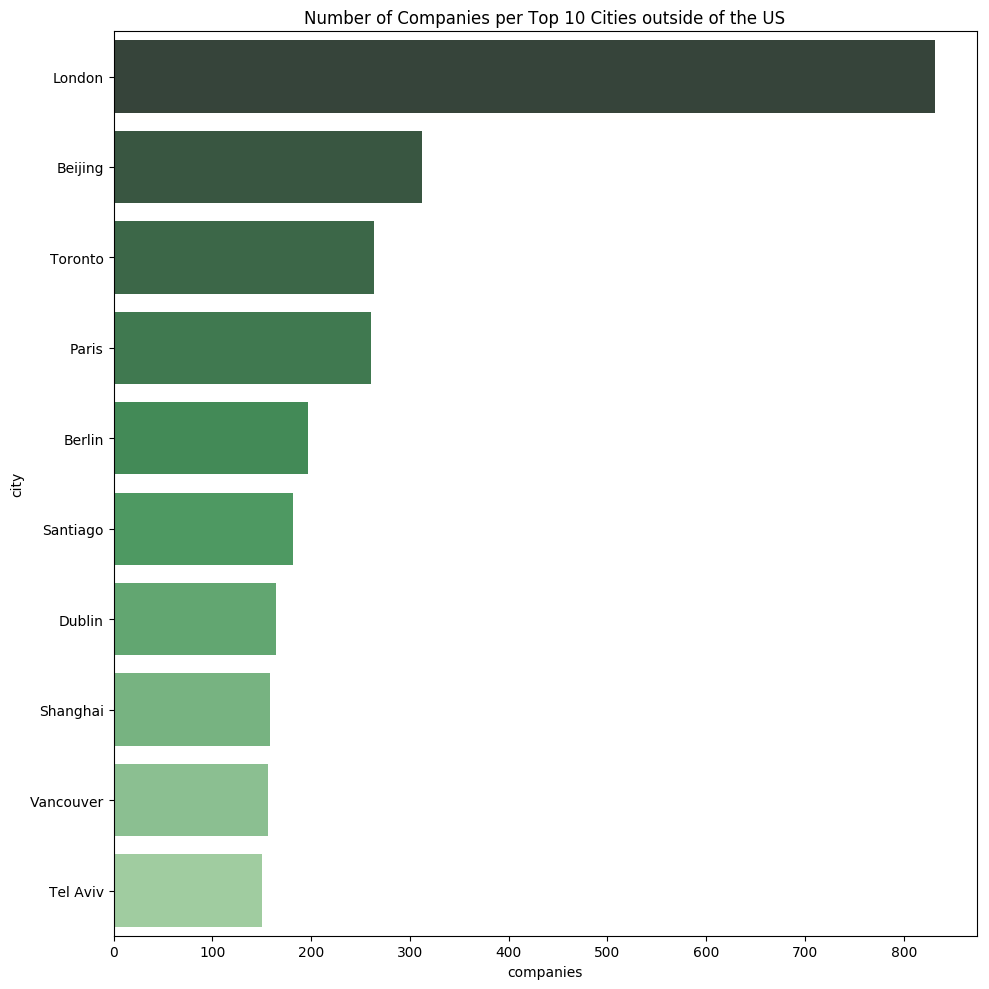

In [59]:
cities_nonusa = master_non_usa.groupby(['city'])[['name']].nunique()
cities_nonusa.columns = ['companies']
cities_nonusa = cities_nonusa.reset_index().sort_values(by=['companies'], ascending=False)

top10_cities_nonusa = cities_nonusa.head(10)
plt.figure(figsize=(10,10))
sns.barplot(y ='city', x='companies',data = top10_cities_nonusa,palette ="Greens_d")
#plt.tight_layout()
plt.title('Number of Companies per Top 10 Cities outside of the US')
plt.savefig('cities_nonusa.png', dpi=300, transparent=True)

In [60]:
countries.nonusa = countries[countries != 'USA']

Text(0.5,1,'Top 10 countries by number of companies')

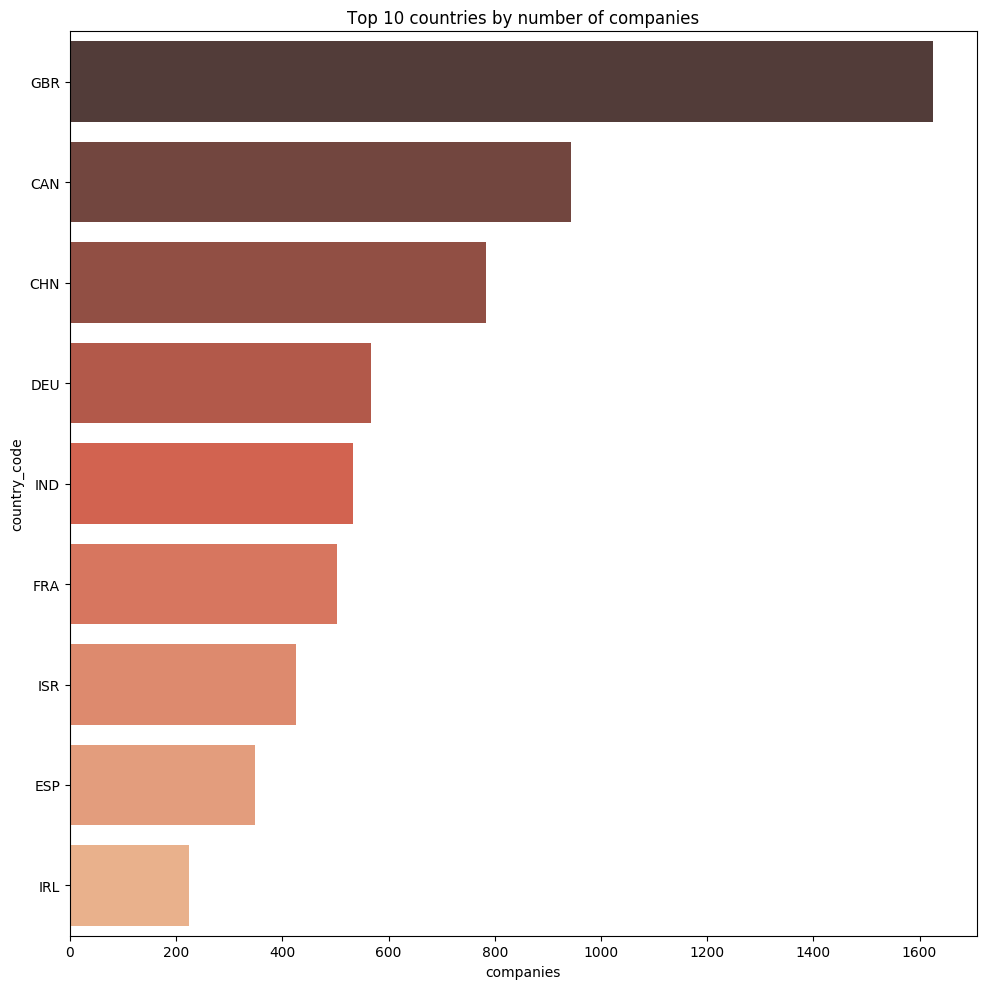

In [64]:
top10_countries = countries.nonusa.head(10)
plt.figure(figsize=(10,10))
sns.barplot(y ='country_code', x='companies',data = top10_countries, palette='OrRd_d')
plt.title('Top 10 countries by number of companies')

<Figure size 640x480 with 0 Axes>

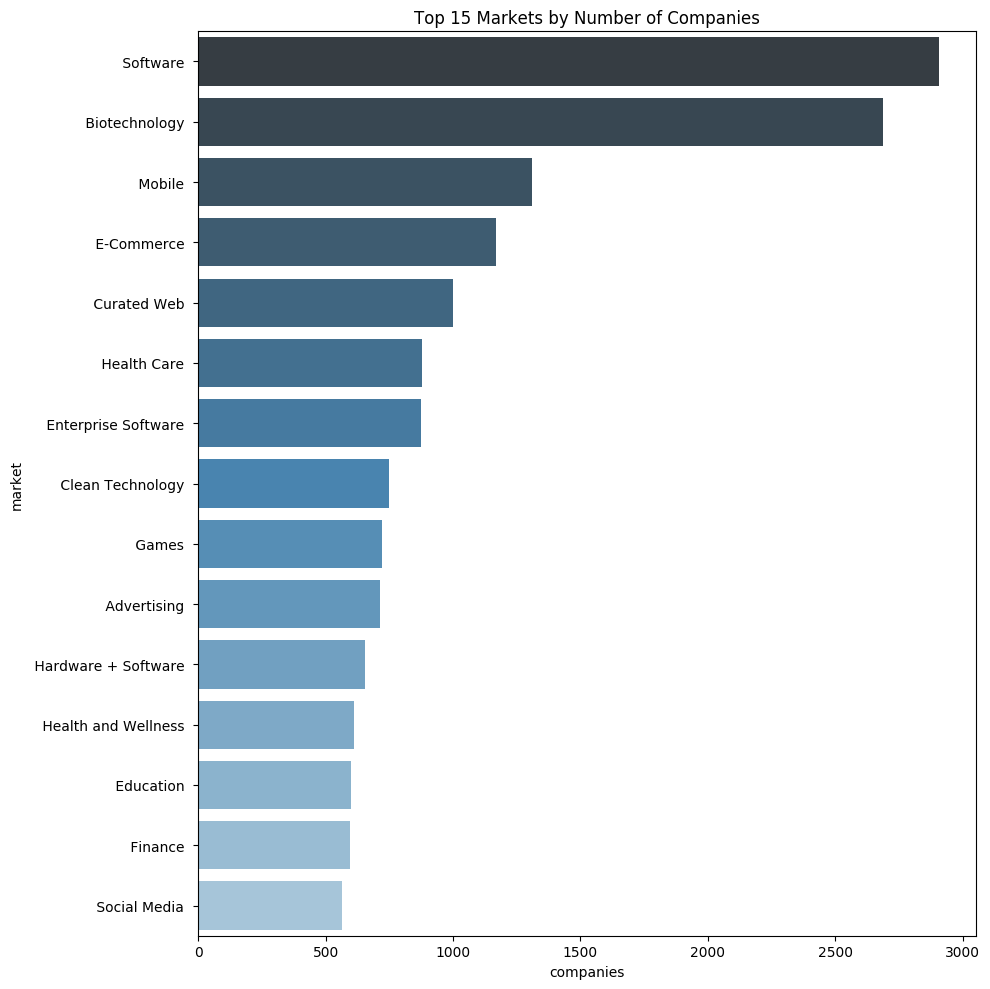

In [65]:
industry = master.groupby(['market'])[['name']].nunique()
industry.columns = ['companies']
industry = industry.reset_index().sort_values(by=['companies'], ascending=False)
top15_industry = industry.head(15)
fig = plt.figure()
plt.figure(figsize=(10,10))
sns.barplot(y ='market', x='companies',data = top15_industry,palette="Blues_d")
#plt.tight_layout()
plt.title('Top 15 Markets by Number of Companies')
plt.savefig('industry_top_15.png', dpi=300, transparent=True)

In [66]:
funding_industry = master.groupby(['market'])[['funding_total_usd']].sum().sort_values(by='funding_total_usd',
                                                                                       ascending=False)

In [67]:
funding_industry.head(10)

,funding_total_usd
market,
Biotechnology,58250022287.0000
Mobile,42256280396.0000
Software,30186755847.0000
Clean Technology,28450592332.0000
Health Care,24975114324.0000
E-Commerce,16437512920.0000
Enterprise Software,15259272938.0000
Finance,13868740190.0000
Advertising,9689181159.0000


In [68]:
# For the purposes of this project, we define startups as companies founded 
# after the Dotcom bubble crash, i.e. the year 2000
master['startup'] = 0
master['startup'][(master['founded_year'] > 2000)] = 1

In [70]:
master['gbr'] = 0
master['gbr'][master['country_code'] == 'GBR']=1

In [71]:
master['deu'] = 0
master['deu'][master['country_code'] == 'DEU']=1

In [72]:
master['can'] = 0
master['can'][master['country_code'] == 'CAN']=1

In [73]:
master['chn'] = 0
master['chn'][master['country_code'] == 'CHN']=1

In [181]:
startups = master[(master['startup'] == 1)]

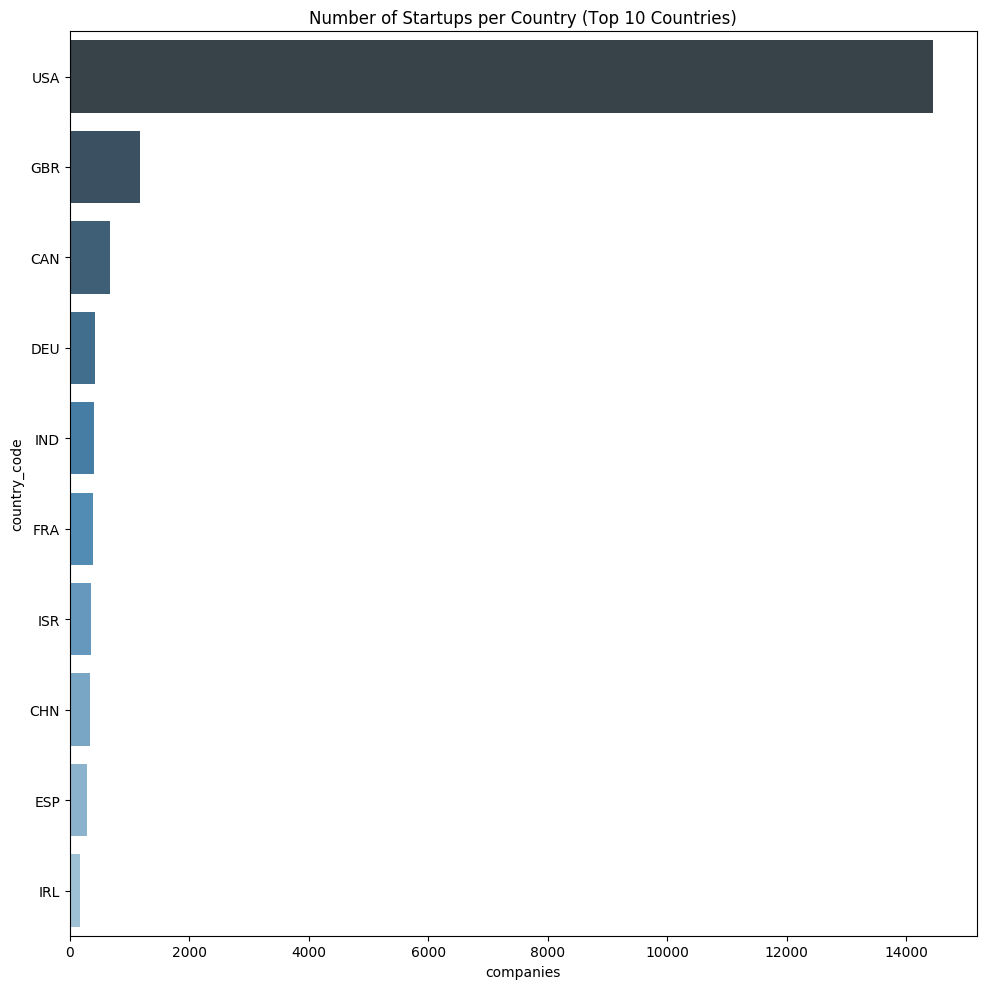

In [77]:
countries = startups.groupby(['country_code'])[['name']].nunique()
countries.columns = ['companies']
countries = countries.reset_index().sort_values(by=['companies'], ascending=False)

top10_countries = countries.head(10)
plt.figure(figsize=(10,10))
plt.title('Number of Startups per Country (Top 10 Countries)')
sns.barplot(y ='country_code', x='companies',data = top10_countries, palette="Blues_d")
#plt.tight_layout()
plt.savefig('startups_per_country_top10.png', dpi=300, transparent=True)

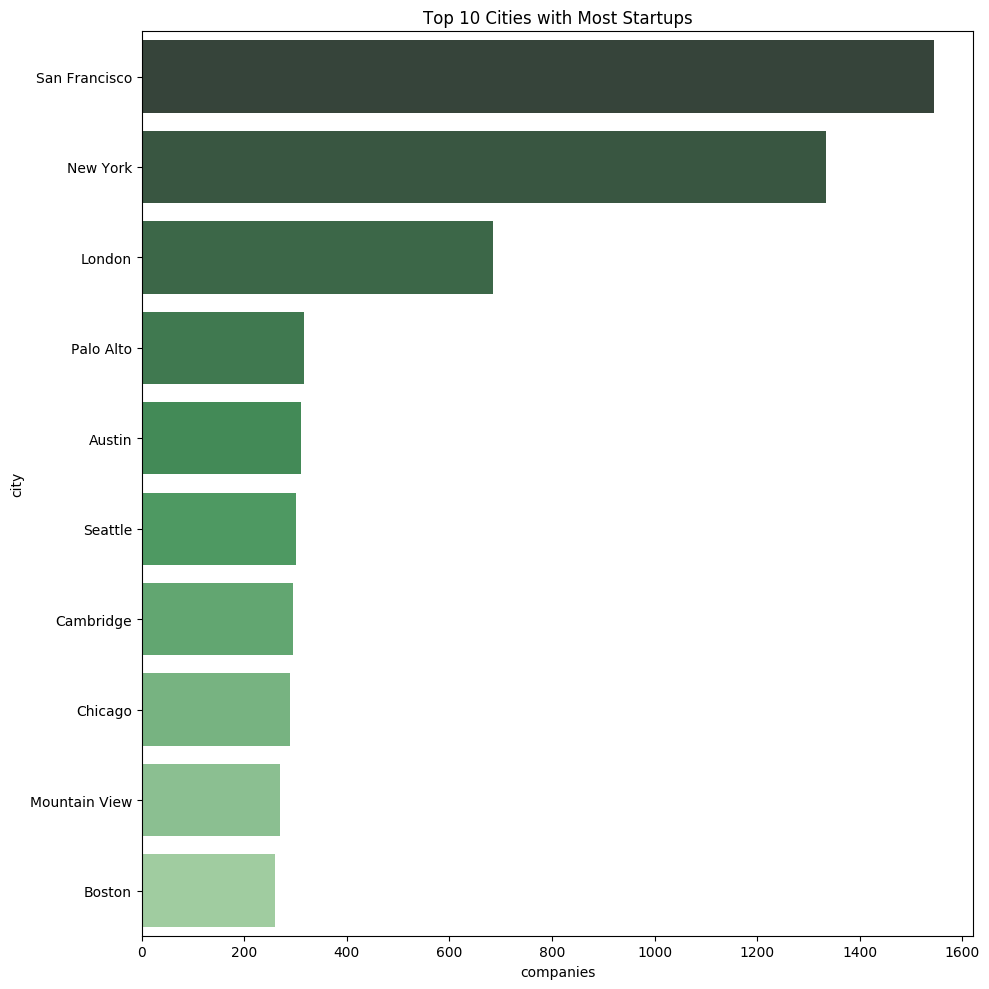

In [78]:
cities = startups.groupby(['city'])[['name']].nunique()
cities.columns = ['companies']
cities = cities.reset_index().sort_values(by=['companies'], ascending=False)

top10_cities = cities.head(10)
plt.figure(figsize=(10,10))
sns.barplot(y ='city', x='companies',data = top10_cities, palette="Greens_d")
#plt.tight_layout()
plt.title('Top 10 Cities with Most Startups')
plt.savefig('top10_cities_startups.png', dpi=300, transparent=True)

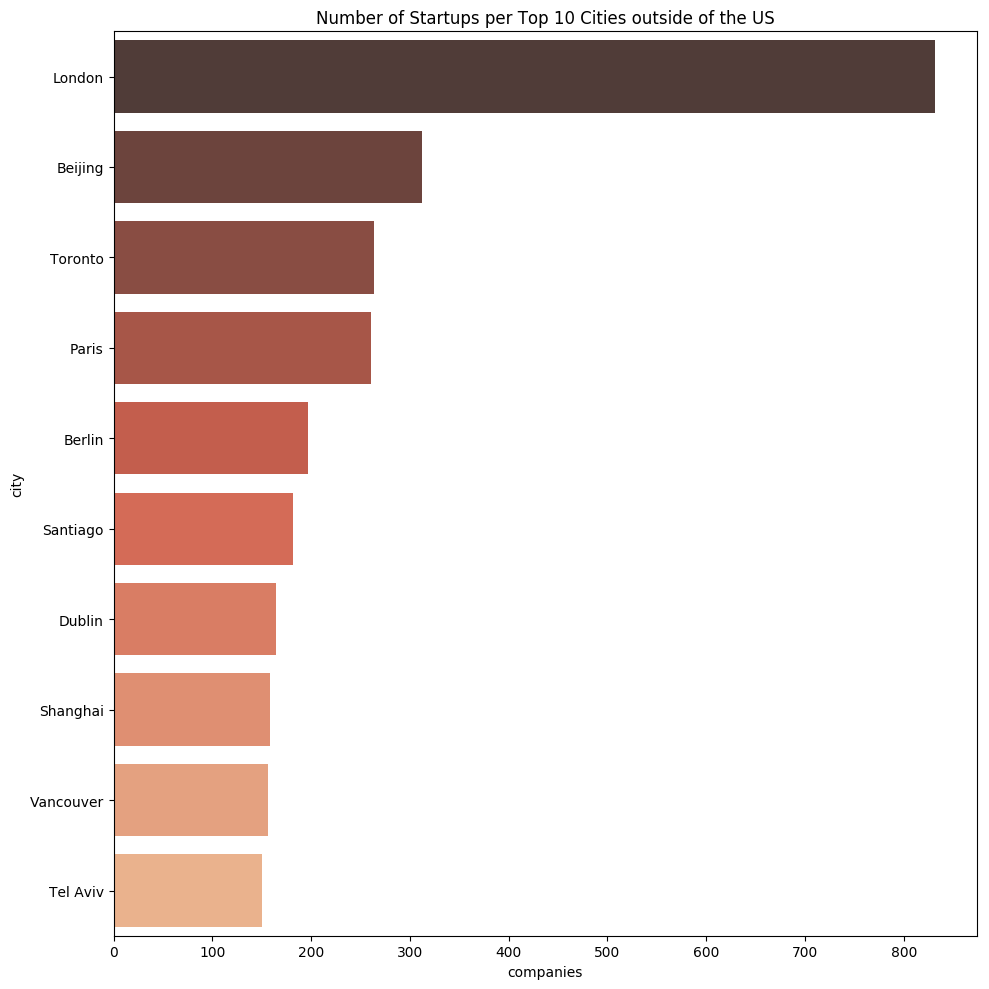

In [79]:
cities_nonusa = master[master['country_code'] != 'USA'].groupby(['city'])[['name']].nunique()
cities_nonusa.columns = ['companies']
cities_nonusa = cities_nonusa.reset_index().sort_values(by=['companies'], ascending=False)

top10_cities_nonusa = cities_nonusa.head(10)
plt.figure(figsize=(10,10))
sns.barplot(y ='city', x='companies',data = top10_cities_nonusa,palette ="OrRd_d")
#plt.tight_layout()
plt.title('Number of Startups per Top 10 Cities outside of the US')
plt.savefig('cities_nonusa_startups.png', dpi=300, transparent=True)

<Figure size 640x480 with 0 Axes>

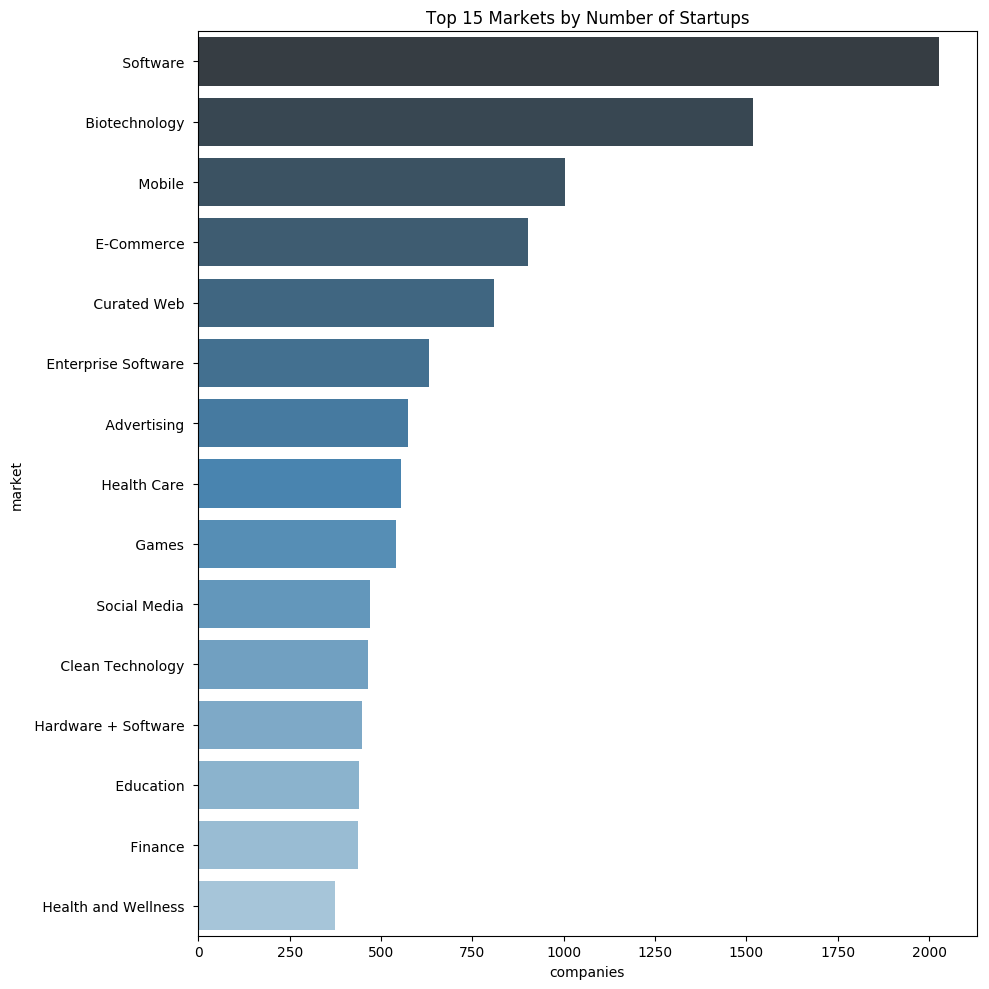

In [80]:
industry = startups.groupby(['market'])[['name']].nunique()
industry.columns = ['companies']
industry = industry.reset_index().sort_values(by=['companies'], ascending=False)
top15_industry = industry.head(15)
fig = plt.figure()
plt.figure(figsize=(10,10))
sns.barplot(y ='market', x='companies',data = top15_industry,palette="Blues_d")
#plt.tight_layout()
plt.title('Top 15 Markets by Number of Startups')
plt.savefig('industry_top_15_startups.png', dpi=300, transparent=True)

In [81]:
funding_industry = startups.groupby(['market'])[['funding_total_usd']].sum().sort_values(by='funding_total_usd',ascending=False)

In [82]:
funding_industry.head(10)

,funding_total_usd
market,
Biotechnology,32024502591.0000
Clean Technology,18647070579.0000
Software,17578793463.0000
Health Care,15122461899.0000
E-Commerce,10656182641.0000
Enterprise Software,10430323420.0000
Mobile,8393587904.0000
Advertising,7327345251.0000
Technology,7261657143.0000


In [182]:
startups.status.value_counts()

operating    20630
acquired      1379
closed         586
Name: status, dtype: int64

<Figure size 640x480 with 0 Axes>

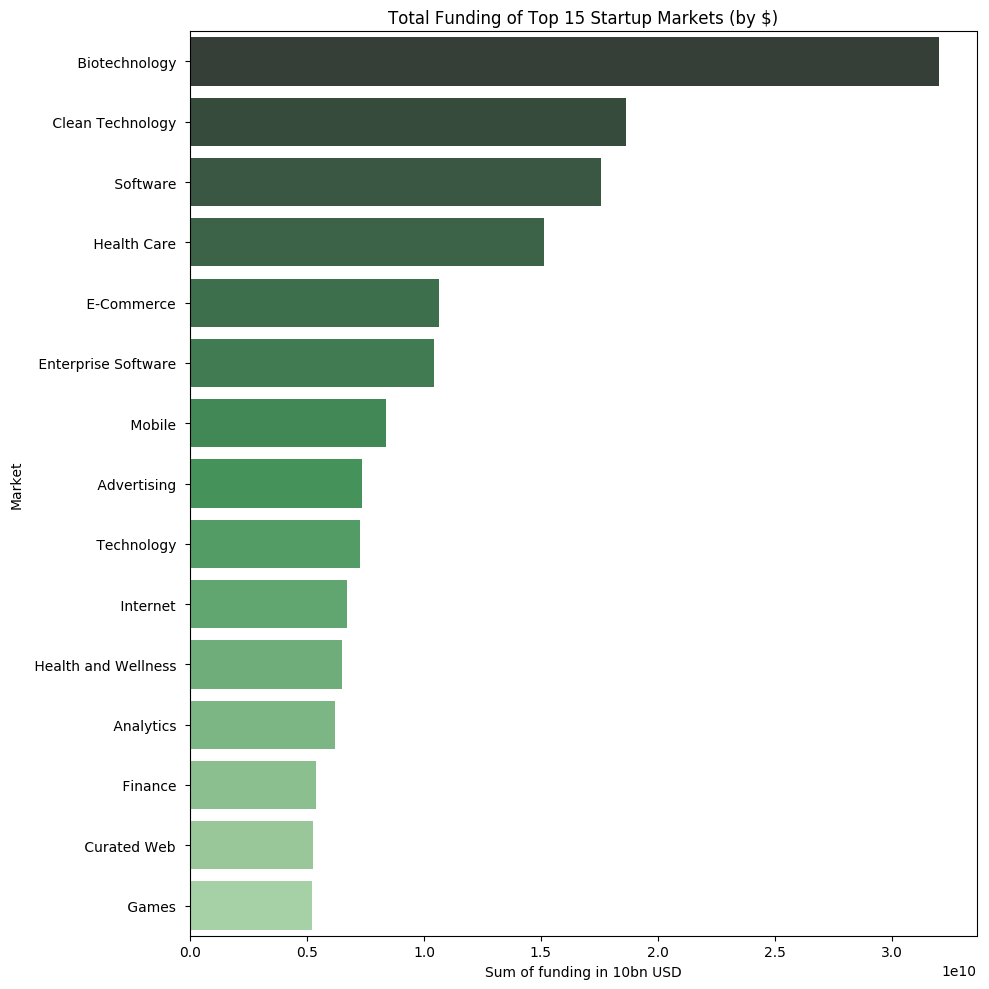

In [84]:
#industry by of funding
fundingindustry_startups = startups.groupby(['market'])[['funding_total_usd']].sum()
fundingindustry_startups.columns = ['funding_total_usd']
fundingindustry_startups = fundingindustry_startups.reset_index().sort_values(by=['funding_total_usd'], ascending=False)
top10_fundingindustry_startups = fundingindustry_startups.head(15)
fig = plt.figure()
plt.figure(figsize=(10,10))
sns.barplot(y ='market', x='funding_total_usd',data = top10_fundingindustry_startups, palette="Greens_d")
plt.xlabel('Sum of funding in 10bn USD')
plt.ylabel('Market')
plt.title('Total Funding of Top 15 Startup Markets (by $)')
plt.tight_layout()
plt.savefig('industry_funding_usd.png', dpi=300, transparent=True)

<Figure size 640x480 with 0 Axes>

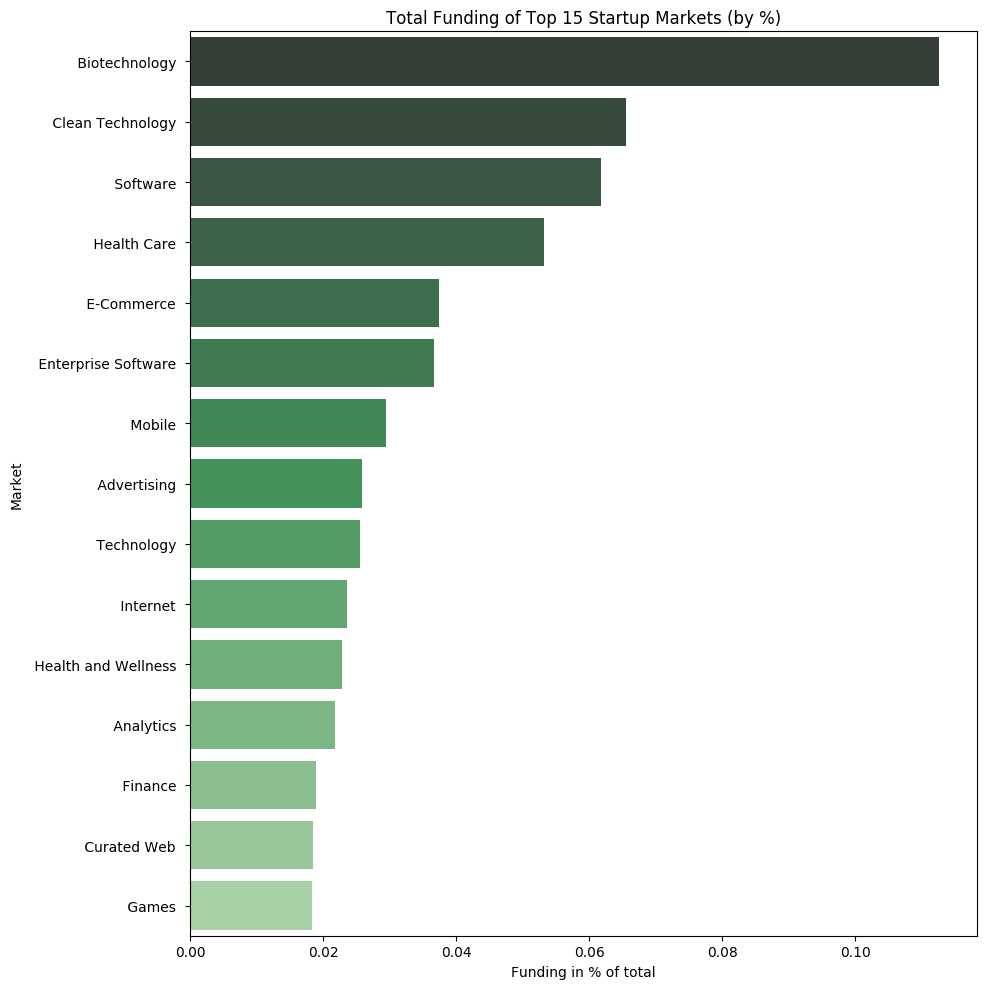

In [85]:
#industry by of funding percentage
fundingindustry_startups = startups.groupby(['market'])[['funding_total_usd']].sum()
fundingindustry_startups.columns = ['funding_total_usd']
fundingindustry_startups['funding_percent'] = fundingindustry_startups['funding_total_usd'] / startups['funding_total_usd'].sum()
fundingindustry_startups = fundingindustry_startups.reset_index().sort_values(by=['funding_percent'], ascending=False)
top10_fundingindustry_startups = fundingindustry_startups.head(15)
fig = plt.figure()
plt.figure(figsize=(10,10))
sns.barplot(y ='market', x='funding_percent',data = top10_fundingindustry_startups,palette="Greens_d")
plt.xlabel('Funding in % of total')
plt.ylabel('Market')
plt.title('Total Funding of Top 15 Startup Markets (by %)')
plt.tight_layout()
plt.savefig('industry_funding_per.png', dpi=300, transparent=True)

In [86]:
top10_fundingindustry_startups.head(20)

,market,funding_total_usd,funding_percent
54,Biotechnology,32024502591.0000,0.1126
84,Clean Technology,18647070579.0000,0.0656
561,Software,17578793463.0000,0.0618
265,Health Care,15122461899.0000,0.0532
174,E-Commerce,10656182641.0000,0.0375
202,Enterprise Software,10430323420.0000,0.0367
371,Mobile,8393587904.0000,0.0295
7,Advertising,7327345251.0000,0.0258
591,Technology,7261657143.0000,0.0255
308,Internet,6717472953.0000,0.0236


In [87]:
startups.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
funding_total_usd,23299.0000,12208428.5939,66625369.5159,0.0000,65035.0000,1000000.0000,6000000.0000,5700000000.0000
funding_rounds,23299.0000,1.8769,1.4318,1.0000,1.0000,1.0000,2.0000,17.0000
founded_year,23299.0000,2009.3767,3.2251,2001.0000,2007.0000,2010.0000,2012.0000,2014.0000
crunchbase_uuid,23299.0000,3.6830,6.3682,1.0000,1.0000,2.0000,4.0000,536.0000
closed,23299.0000,0.0252,0.1566,0.0000,0.0000,0.0000,0.0000,1.0000
operating,23299.0000,0.8854,0.3185,0.0000,1.0000,1.0000,1.0000,1.0000
acquired,23299.0000,0.0592,0.2360,0.0000,0.0000,0.0000,0.0000,1.0000
usa,23299.0000,0.6213,0.4851,0.0000,0.0000,1.0000,1.0000,1.0000
startup,23299.0000,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
gbr,23299.0000,0.0507,0.2195,0.0000,0.0000,0.0000,0.0000,1.0000


In [88]:
startups.founded_year = startups.founded_year.astype(int)
startups.market = startups.market.astype(str)

In [91]:
# Aggregate people by organisation/company
countries_stats = startups.groupby(['country_code']).agg({'funding_total_usd': "sum",
                                                   'city': "nunique",
                                                   'name': 'nunique',
                                                    'closed': "sum",
                                                         'operating': 'sum',
                                                         'acquired':'sum'}).sort_values(by="funding_total_usd",
                                                                                  ascending=False)

countries_stats['closed_per'] = countries_stats['closed'] / countries_stats['name']
countries_stats['operating_per'] = countries_stats['operating'] / countries_stats['name']
countries_stats['acquired_per'] = countries_stats['acquired'] / countries_stats['name']

countries_stats.head(5)

,funding_total_usd,city,name,closed,operating,acquired,closed_per,operating_per,acquired_per
country_code,,,,,,,,,
USA,217839491938.0000,1610,14454,374,12634,1080,0.0259,0.8741,0.0747
CHN,14224551919.0000,30,333,3,320,6,0.0090,0.9610,0.0180
GBR,9119870921.0000,175,1181,23,1090,40,0.0195,0.9229,0.0339
CAN,4949441250.0000,71,666,15,580,41,0.0225,0.8709,0.0616
DEU,3756807661.0000,81,423,8,370,28,0.0189,0.8747,0.0662


In [183]:
startups['age'] = 2018 - startups['founded_year']

In [184]:
# Issues with time_between_fundings calculation, therefore export to csv (formatting will be repaired in MS Excel)
startups.to_csv('startups.csv')

In [217]:
startups = pd.read_csv("https://raw.githubusercontent.com/MiriamHruzova/DEDA_class_2018_Sucess_of_startups/master/startups_new.csv", encoding='mac_roman')

In [218]:
startups.status.value_counts()

operating    20630
acquired      1379
closed         586
Name: status, dtype: int64

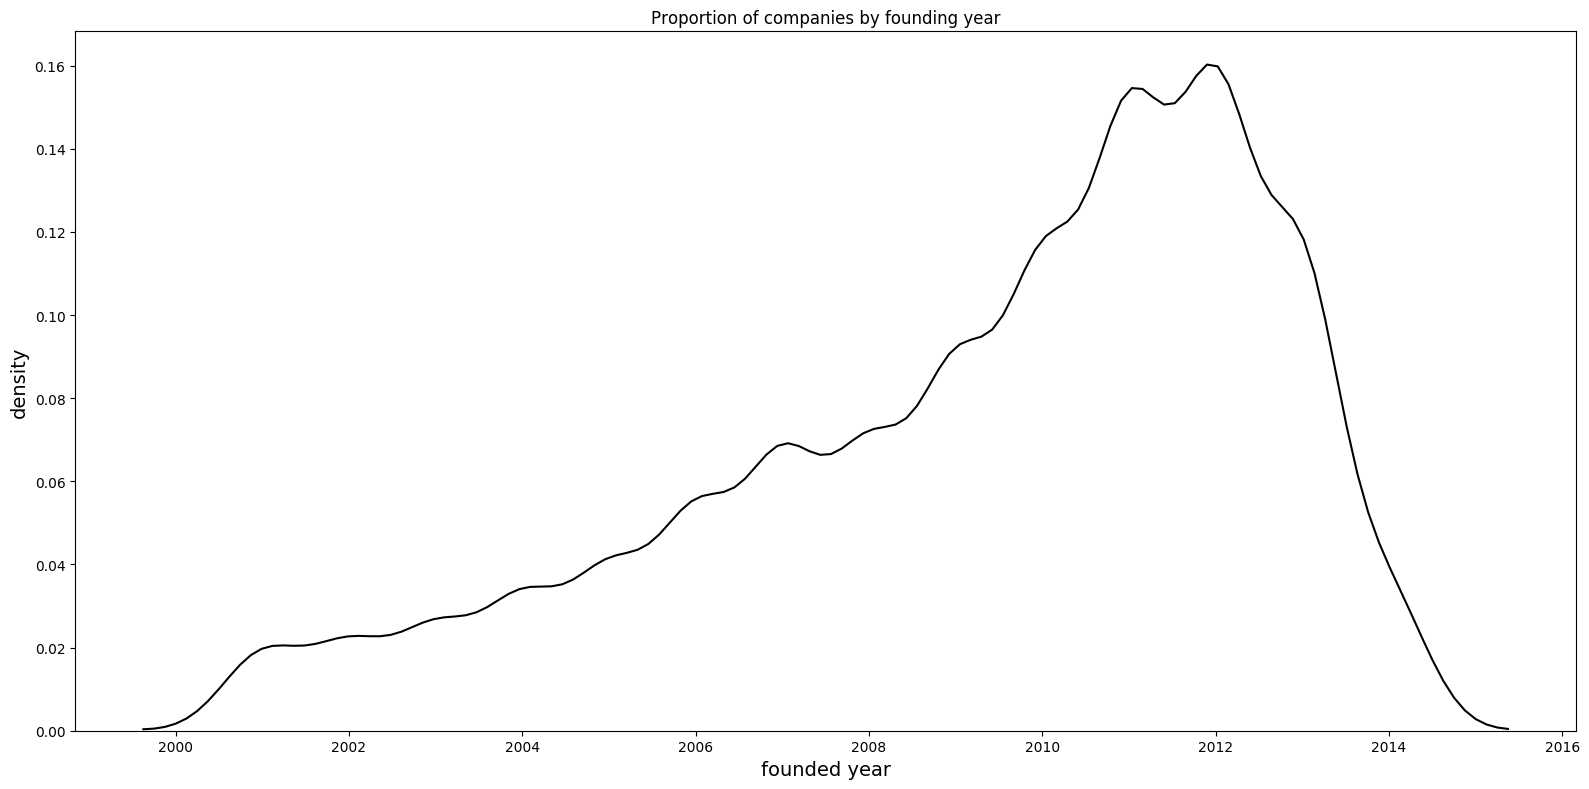

In [97]:
plt.figure(figsize=(16,8))
sns.kdeplot(startups['founded_year'], color="black", legend=False)
plt.xlabel('founded year',fontsize=14)
plt.ylabel('density',fontsize=14)
plt.tight_layout()
plt.title('Proportion of companies by founding year')
plt.savefig('year_of_founding.png', dpi=300, transparent=True)

In [223]:
startups.columns

Index(['name', 'homepage_url', 'market', 'funding_total_usd', 'status',
       'country_code', 'state_code', 'region', 'city', 'funding_rounds',
       'founded_at', 'founded_month', 'founded_quarter', 'founded_year',
       'first_funding_at', 'last_funding_at', 'time_between_fundings',
       'organization', 'crunchbase_uuid', 'closed', 'operating', 'acquired',
       'usa', 'startup', 'gbr', 'deu', 'can', 'chn', 'age'],
      dtype='object')

In [230]:
startups_new = startups[['market',
                         'funding_total_usd',
                         'funding_rounds',
                         'status',
                         'country_code',
                         'city',
                         'founded_year',
                         'crunchbase_uuid',
                         'age',
                         'time_between_fundings']]

In [231]:
startups_status = pd.get_dummies(startups_new.status)
startups_countries = pd.get_dummies(startups_new.country_code)
startups_cities = pd.get_dummies(startups_new.city)
startups_markets = pd.get_dummies(startups_new.market)

In [232]:
st_master = pd.concat([startups_new,startups_status,startups_countries,startups_cities, startups_markets],axis=1)

In [233]:
st_fin = st_master.copy()

In [106]:
crunchbase_2013 = pd.read_csv('https://raw.githubusercontent.com/datahoarder/crunchbase-october-2013/master/crunchbase-rounds.csv', encoding='mac roman')

In [109]:
# Loading additional data to analyse every founding raised per round:

In [110]:
crunchbase_2013_grouped = crunchbase_2013.groupby(['company_name']).agg({'raised_amount_usd': "mean"})

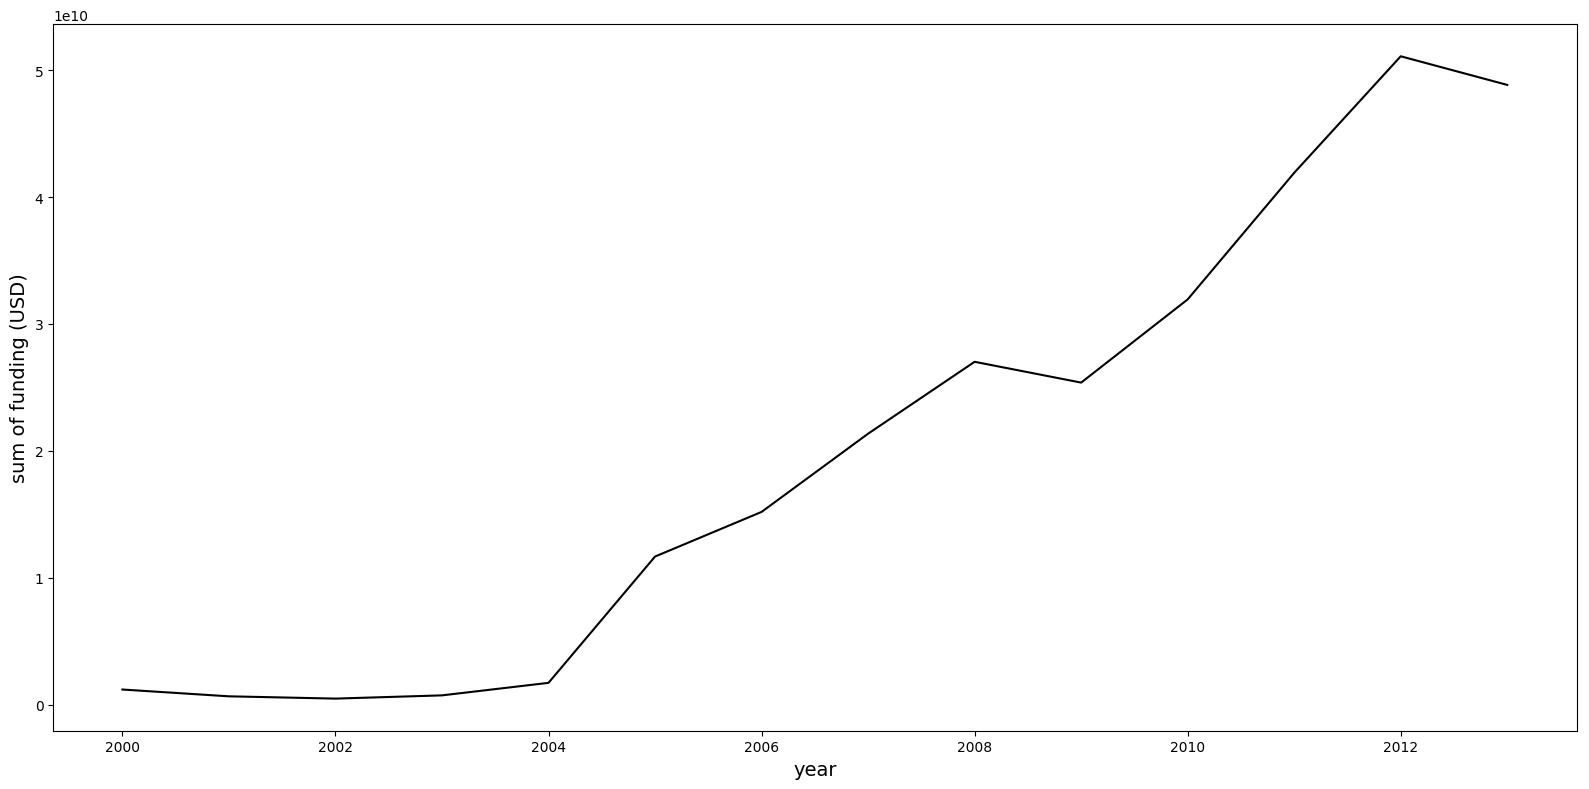

In [111]:
crunchbase_2013_after2000 = crunchbase_2013[(crunchbase_2013['funded_year'] >= 2000)]
crunchbase_2013_year = crunchbase_2013_after2000.groupby(['funded_year']).agg({'raised_amount_usd': "sum"})

plt.figure(figsize=(16,8))
plt.plot(crunchbase_2013_year, color="black")
plt.xlabel('year', fontsize=14)
plt.ylabel('sum of funding (USD)', fontsize=14)
plt.tight_layout()
plt.savefig('sum_funding.png', dpi=300, transparent=True)

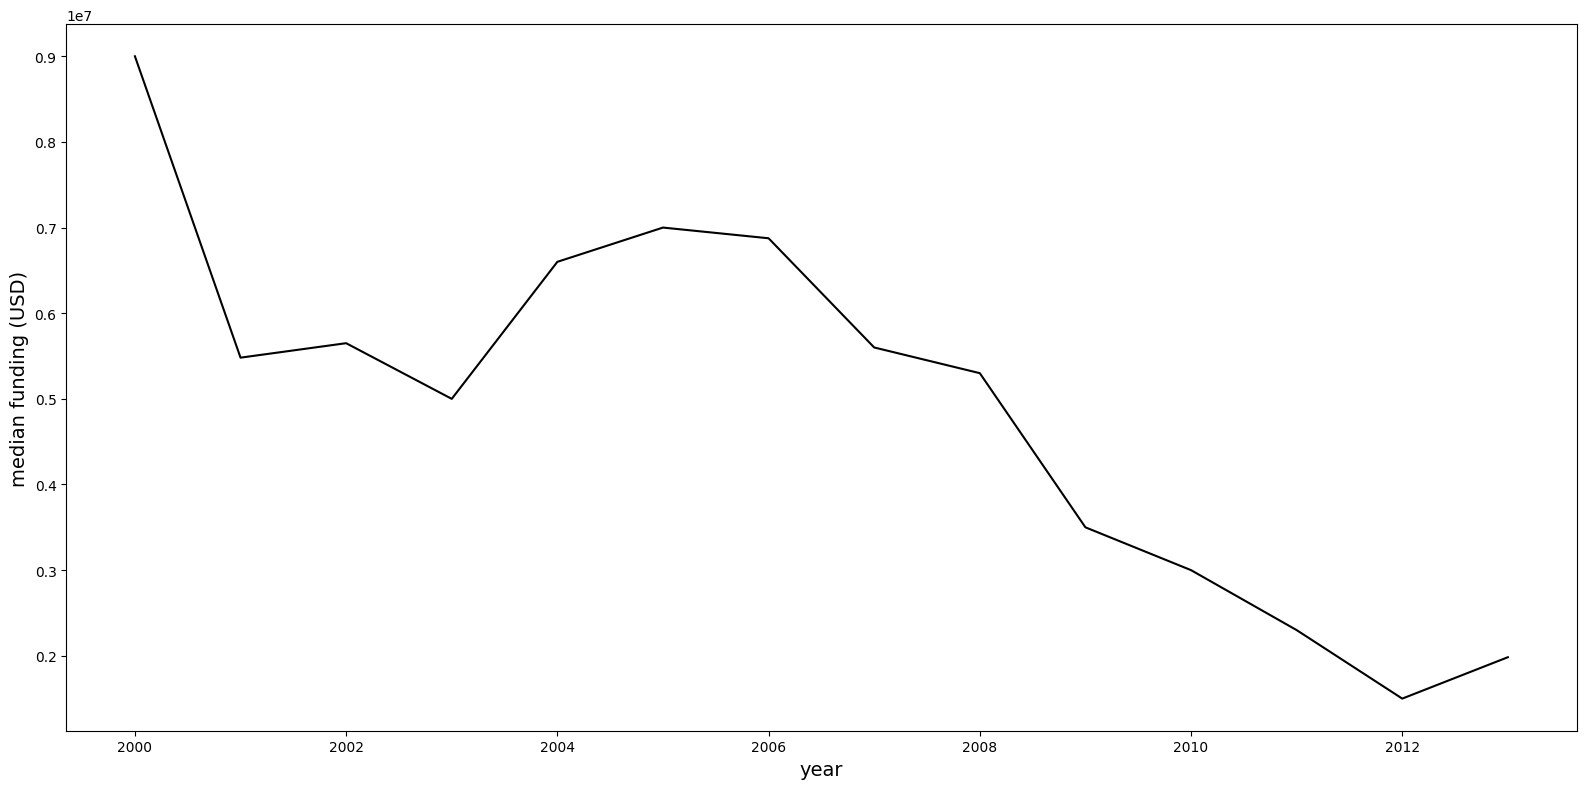

In [112]:
crunchbase_2013_year = crunchbase_2013_after2000.groupby(['funded_year']).agg({'raised_amount_usd': "median"})

plt.figure(figsize=(16,8))
plt.plot(crunchbase_2013_year, color="black")
plt.xlabel('year', fontsize=14)
plt.ylabel('median funding (USD)', fontsize=14)
plt.tight_layout()
plt.savefig('median_funding.png', dpi=300, transparent=True)

# Making Predictions for Closed Startups

In [662]:
st_fin = startups[['market', 
                   'funding_total_usd',
                   'country_code',
                   'city',
                   'funding_rounds', 
                   'founded_year', 
                   'crunchbase_uuid',
                   'closed',
                   'time_between_fundings',
                   'age']].dropna()

In [663]:
st_status = st_fin[['closed']]
st_features = st_fin[['market',
                      'funding_total_usd',
                      'country_code',
                      'funding_rounds',
                     'founded_year',
                      'crunchbase_uuid', 
                      'age',
                      'time_between_fundings'
                     ]]

In [664]:
st_status.closed.value_counts()

0    19465
1      512
Name: closed, dtype: int64

In [665]:
st_features.describe()

,funding_total_usd,funding_rounds,founded_year,crunchbase_uuid,age,time_between_fundings
count,19977.0000,19977.0000,19977.0000,19977.0000,19977.0000,19977.0000
mean,13542054.3931,1.9629,2009.1829,3.8357,8.8171,409.8979
std,71424398.3038,1.4909,3.2221,6.7672,3.2221,677.0856
min,0.0000,1.0000,2001.0000,1.0000,4.0000,0.0000
25%,100000.0000,1.0000,2007.0000,1.0000,6.0000,0.0000
50%,1200000.0000,1.0000,2010.0000,3.0000,8.0000,0.0000
75%,7335875.0000,2.0000,2012.0000,4.0000,11.0000,630.0000
max,5700000000.0000,17.0000,2014.0000,536.0000,17.0000,19578.0000


In [666]:
st_features = pd.get_dummies(st_features)

In [667]:
st_master = pd.concat([st_status,st_features],axis=1)

In [668]:
st_master.head()

,closed,funding_total_usd,funding_rounds,founded_year,crunchbase_uuid,age,time_between_fundings,market_ 3D,market_ 3D Printing,market_ 3D Technology,...,country_code_TUR,country_code_TWN,country_code_TZA,country_code_UGA,country_code_UKR,country_code_URY,country_code_USA,country_code_UZB,country_code_VNM,country_code_ZAF
0,0,1750000,1,2012,2,6,0.0000,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,40000,1,2012,2,6,0.0000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1500000,1,2011,3,7,0.0000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,10000,1,2014,1,4,0.0000,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,7000000,1,2011,1,7,0.0000,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [669]:
# Balancing data for Machine Learning to avoid bias

# Separate majority and minority classes
closed_majority = st_master[st_master.closed==0]
closed_minority = st_master[st_master.closed==1]
 
# Downsample majority class
closed_majority_downsampled = resample(closed_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=512,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
closed_downsampled = pd.concat([closed_majority_downsampled, closed_minority])
 
# Display new class counts
closed_downsampled.closed.value_counts()

1    512
0    512
Name: closed, dtype: int64

In [670]:
X_log_closed = closed_downsampled.loc[:,'funding_total_usd':]
y_log_closed = closed_downsampled['closed']

In [719]:
selector_f = SelectKBest(f_regression, k='all')
selector_f.fit(X_log_closed, y_log_closed)

name_var = [X_log_closed.columns]
var_score = selector_f.scores_

kbest = pd.DataFrame(var_score, name_var).sort_values(by=0, ascending=False).head(5).reset_index()
kbest.columns = ['var', 'score']

In [720]:
f_reg_var = kbest['var'].tolist()

In [721]:
f_reg_var

['crunchbase_uuid',
 'time_between_fundings',
 'market_ Biotechnology ',
 'funding_rounds',
 'market_ Social Media ']

In [722]:
closed_log = sm.Logit(closed_downsampled['closed'], closed_downsampled[f_reg_var]).fit()
print(closed_log.summary())

Optimization terminated successfully.
         Current function value: 0.656749
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 closed   No. Observations:                 1024
Model:                          Logit   Df Residuals:                     1019
Method:                           MLE   Df Model:                            4
Date:                Mon, 02 Jul 2018   Pseudo R-squ.:                 0.05251
Time:                        19:02:18   Log-Likelihood:                -672.51
converged:                       True   LL-Null:                       -709.78
                                        LLR p-value:                 2.488e-15
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
crunchbase_uuid           -0.1393      0.027     -5.178      0.000      -0.192      

In [715]:
master_closed = sklearn.utils.resample(closed_downsampled, random_state=5)

X_closed = master_closed[f_reg_var]

y_closed = master_closed['closed']

X_closed_train, X_closed_test, y_closed_train, y_closed_test = train_test_split(X_closed, 
                                                                                        y_closed,
                                                                                        test_size=0.3,
                                                                                        random_state=5)

print(X_closed_train.shape, y_closed_train.shape)
print(X_closed_test.shape, y_closed_test.shape)

(716, 3) (716,)
(308, 3) (308,)


In [716]:
# Making predictions
logit = LogisticRegression()
model = logit.fit(X_closed_train, y_closed_train)
predictions = logit.predict(X_closed_test)
print("Score:", model.score(X_closed_test, y_closed_test))

Score: 0.6136363636363636


In [717]:
kfold = model_selection.KFold(n_splits=10, random_state=5)
results_logit_acc = model_selection.cross_val_score(logit, X_closed_train, y_closed_train, cv=kfold, scoring='accuracy')
results_logit_pre = model_selection.cross_val_score(logit, X_closed_train, y_closed_train, cv=kfold, scoring='precision')
results_logit_rec = model_selection.cross_val_score(logit, X_closed_train, y_closed_train, cv=kfold, scoring='recall')

print("10-fold cross validation average accuracy: %.3f" % (results_logit_acc.mean()))
print("10-fold cross validation average precision: %.3f" % (results_logit_pre.mean()))
print("10-fold cross validation average recall: %.3f" % (results_logit_rec.mean()))

10-fold cross validation average accuracy: 0.619
10-fold cross validation average precision: 0.585
10-fold cross validation average recall: 0.753


Normalized confusion matrix
[[0.49714286 0.50285714]
 [0.23308271 0.76691729]]


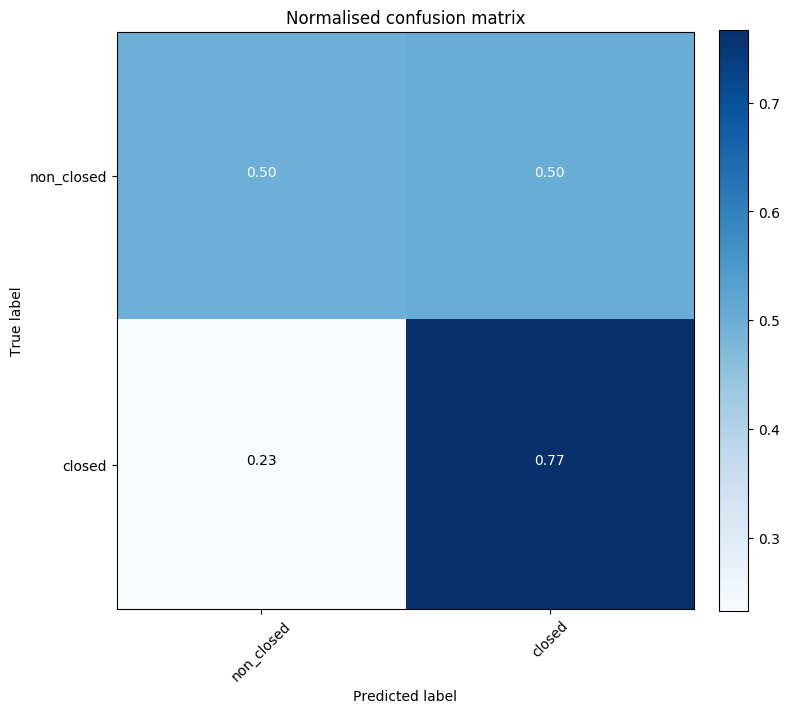

In [718]:
confusion_matrix_log = confusion_matrix(y_closed_test, predictions)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names=["non_closed","closed"]    

# Plot non-normalized confusion matrix
#plt.figure(figsize=(8,8))
#plot_confusion_matrix(confusion_matrix_log, classes=class_names,
#                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix_log, classes=class_names, normalize=True,
                      title='Normalised confusion matrix')
plt.savefig('confusion_matrix.png', dpi=300, transparent=True)
plt.show()

In [724]:
st_fin.head()

,market,funding_total_usd,country_code,city,funding_rounds,founded_year,crunchbase_uuid,closed,time_between_fundings,age
0,News,1750000,USA,New York,1,2012,2,0,0.0000,6
1,Publishing,40000,EST,Tallinn,1,2012,2,0,0.0000,6
2,Electronics,1500000,GBR,London,1,2011,3,0,0.0000,7
3,Games,10000,USA,Fort Worth,1,2014,1,0,0.0000,4
4,Software,7000000,USA,Oakland Park,1,2011,1,0,0.0000,7


In [792]:
markets = st_fin.groupby(['market']).agg({'market': "count",
                                         'funding_total_usd': 'mean',
                                         'country_code':'nunique',
                                         'city':'nunique',
                                         'funding_rounds':'mean',
                                         'crunchbase_uuid':'mean',
                                         'time_between_fundings':'mean',
                                         'age':'mean',
                                         'closed':'sum'})

In [793]:
markets = markets.rename(columns={'market': 'number_companies'})

In [794]:
markets = markets.reset_index()

In [795]:
bio_soc = markets[(markets['market'] == ' Biotechnology ') | (markets['market'] == ' Social Media ')]

In [796]:
bio_soc['companies/country'] = bio_soc['number_companies'] / bio_soc['country_code']
bio_soc['companies/city'] = bio_soc['number_companies'] / bio_soc['city']
bio_soc['closed_rate'] = bio_soc['closed'] / bio_soc['number_companies']

In [797]:
bio_soc = bio_soc.rename(columns={'funding_total_usd': 'average_funding',
                                 'country_code':'distinct_countries',
                                 'city':'distinct_cities',
                                 'funding_rounds':'average_funding_rounds',
                                         'crunchbase_uuid':'avg_employees_on_crunchbase',
                                         'time_between_fundings':'average_time_between_fundings',
                                         'age':'average_age'})

In [798]:
bio_soc.transpose()

,52,541
market,Biotechnology,Social Media
number_companies,1470,411
average_funding,21118477.0422,5061708.6204
distinct_countries,30,47
distinct_cities,578,185
average_funding_rounds,2.3095,1.8054
avg_employees_on_crunchbase,3.2687,3.0146
average_time_between_fundings,578.3578,329.8078
average_age,10.4932,7.9586
closed,20,29


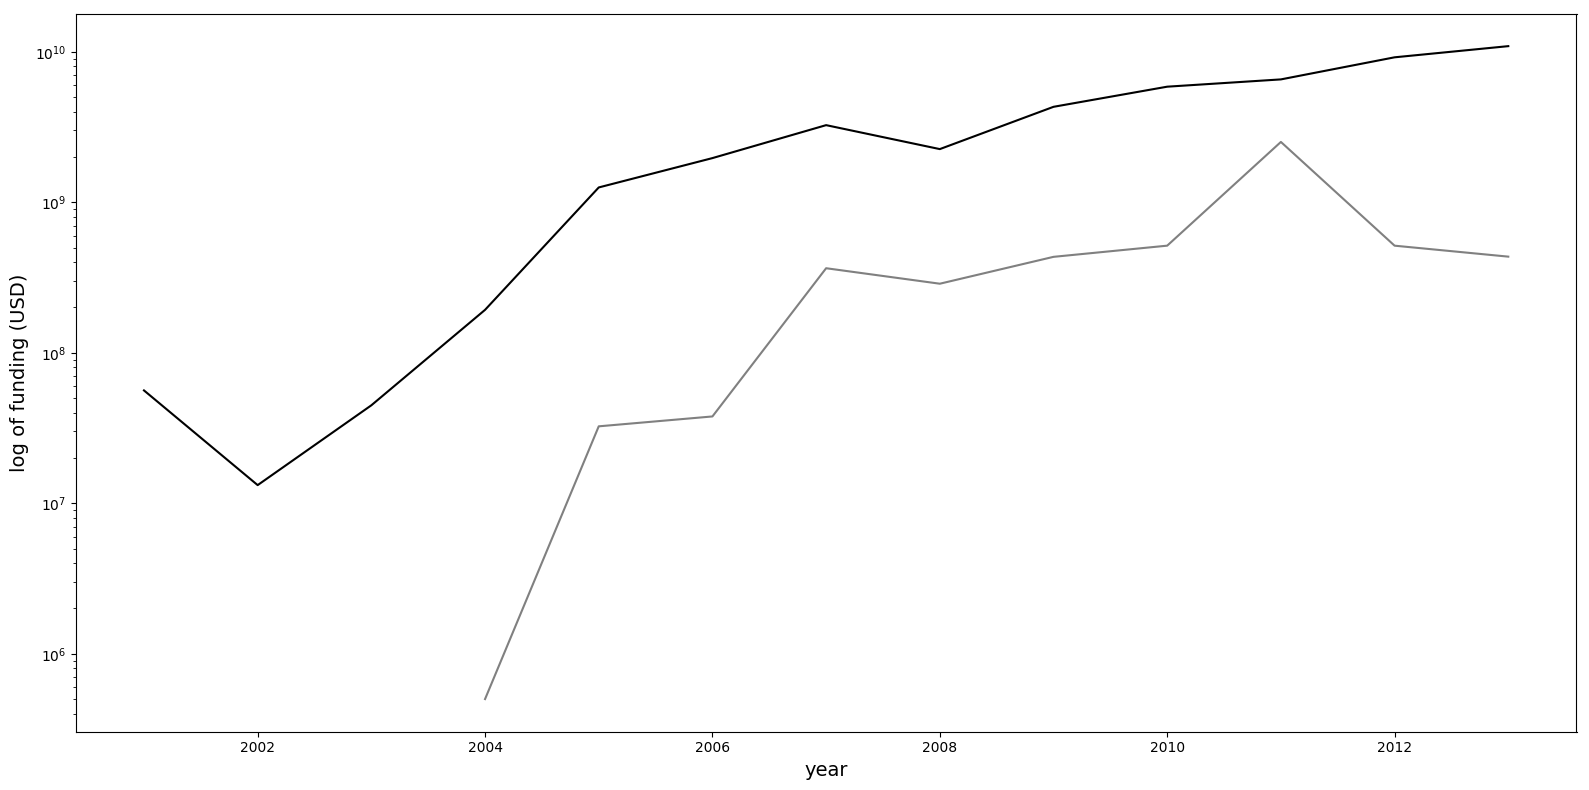

In [775]:
biotech = crunchbase_2013_after2000[(crunchbase_2013_after2000['company_category_code'] == 'biotech')]
biotech_fund = biotech.groupby(['funded_year']).agg({'raised_amount_usd': "sum"})

socmedia = crunchbase_2013_after2000[(crunchbase_2013_after2000['company_category_code'] == 'social')]
socmedia_fund = socmedia.groupby(['funded_year']).agg({'raised_amount_usd': "sum"})

plt.figure(figsize=(16,8))
plt.plot(biotech_fund, color="black")
plt.plot(socmedia_fund, color="gray")
plt.yscale('log')
plt.xlabel('year', fontsize=14)
plt.ylabel('log of funding (USD)', fontsize=14)
plt.tight_layout()
plt.savefig('funding_biotech-vs-social.png', dpi=300, transparent=True)

In [804]:
biotech = st_fin[(st_fin['market'] == ' Biotechnology ')]
social_media = st_fin[(st_fin['market'] == ' Social Media ')]

In [809]:
biotech.country_code.value_counts(normalize=True).head(5)

USA   0.8238
GBR   0.0374
CAN   0.0218
FRA   0.0190
DEU   0.0150
Name: country_code, dtype: float64

In [812]:
social_media.country_code.value_counts(normalize=True).head(5)

USA   0.5645
GBR   0.0584
CAN   0.0365
CHN   0.0292
IND   0.0268
Name: country_code, dtype: float64

In [814]:
bs = st_fin[(st_fin['market'] == ' Biotechnology ') | (st_fin['market'] == ' Social Media ')] 

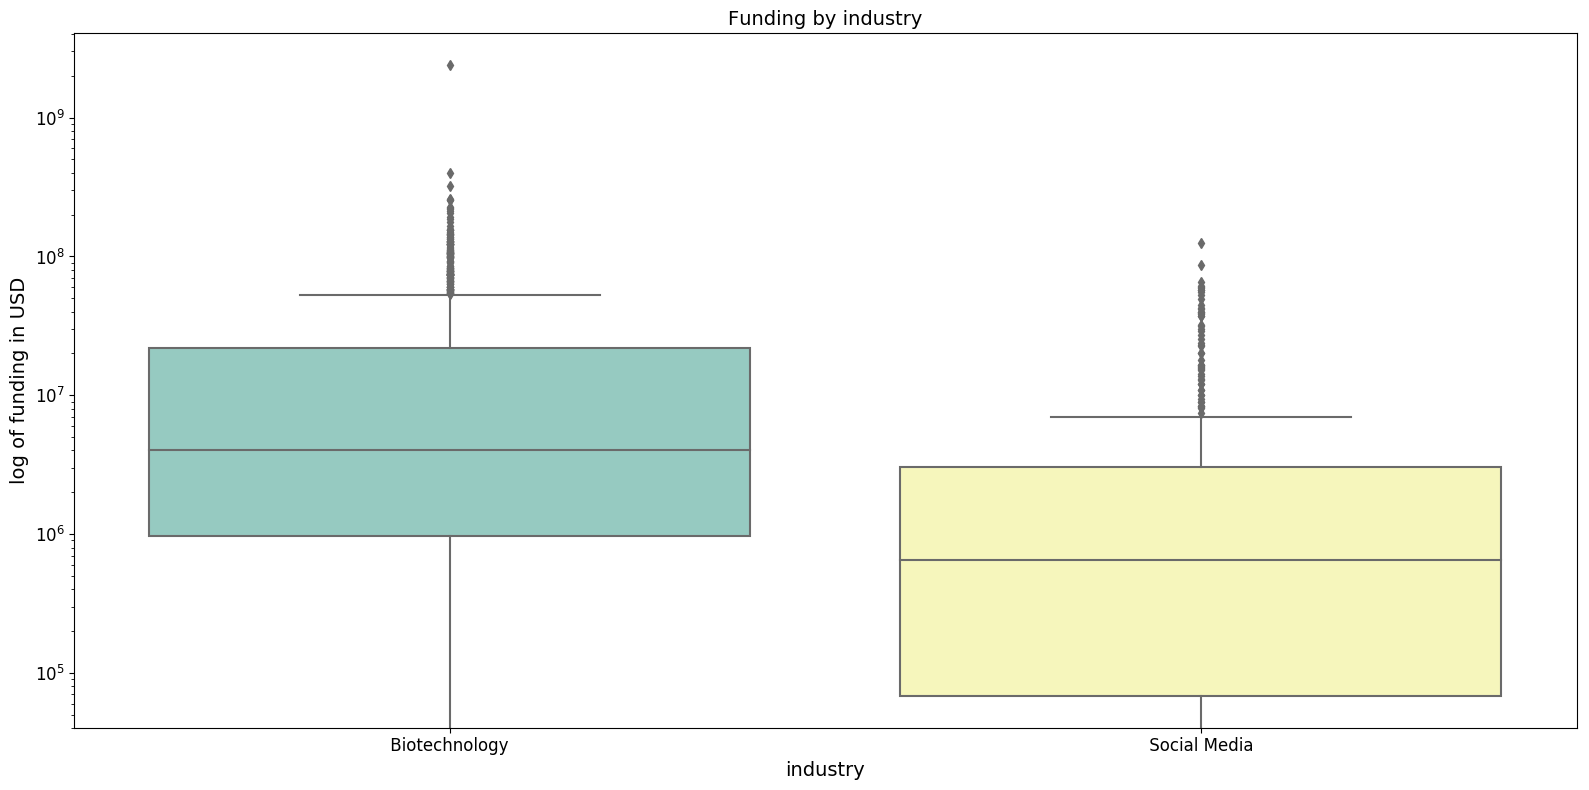

In [824]:
plt.figure(figsize=(16,8))
sns.boxplot(x="market", y="funding_total_usd", data=bs, palette="Set3")
#plt.legend(handles=[US_median],fontsize=12)
plt.xlabel('industry',fontsize=14)
plt.ylabel('log of funding in USD',fontsize=14)
plt.yscale('log')
plt.tick_params(axis='both',labelsize=12)
plt.title('Funding by industry',fontsize=14)
plt.savefig('funding_biotech-vs-social_boxplot.png', dpi=300, transparent=True)